# Tutorial 05: Collision Checks With Dynamic Obstacles

This tutorial shows you how to use the drivability checker library in order to quickly check if multiple ego-vehicle trajectories collide
with a set of dynamic obstacles. The dynamic obstacles could be given by e.g., their predicted trajectories or their
drivable areas.


## 1 Necessary imports and helper functions
We begin by importing all necessary modules and setting up helper functions.

In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

# commonroad
from commonroad.geometry.shape import Polygon, ShapeGroup, Shape, Rectangle
from commonroad.scenario.lanelet import LaneletNetwork
from commonroad.scenario.obstacle import StaticObstacle, ObstacleType
from commonroad.scenario.scenario import Scenario
from commonroad.scenario.trajectory import State, Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction, SetBasedPrediction

#commonroad-io
from commonroad.common.file_reader import CommonRoadFileReader

# commonroad_dc
import commonroad_dc.pycrcc as pycrcc
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object
from commonroad_dc.collision.visualization.draw_dispatch import draw_object
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static
import commonroad_dc.pycrcc.Util as Util

def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set


directory = './'

## 2 Collision checks
We demonstrate the collision checking for two CommonRoad scenarios:
* **USA_US101-3_3_T-1** contains the predicted trajectories of all dynamic obstacles
* **USA_US101-3_3_S-1** uses set-based prediction and contains the predicted drivable areas

We open and visualize the first scenario (trajectory prediction).

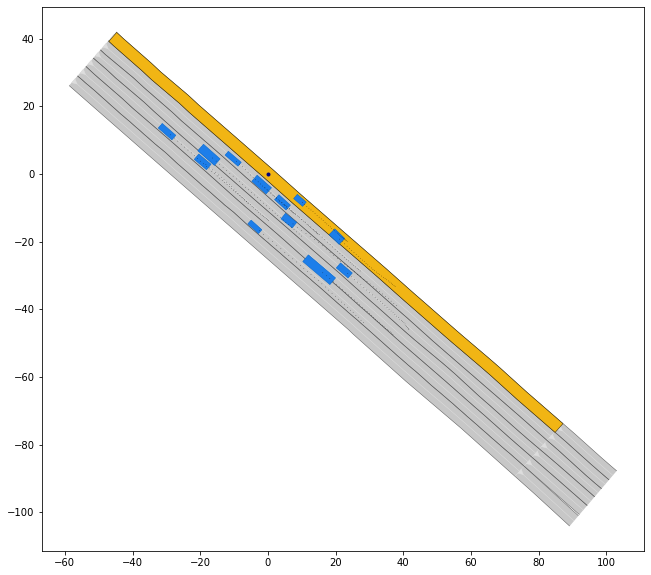

In [143]:
scenario_name_trajectory_prediction="USA_US101-3_3_T-1"
scenario_name_set_prediction="USA_US101-3_3_S-1"


#open the example scenario
scenario, planning_problem_set = open_scenario(directory+scenario_name_trajectory_prediction+'.xml')


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

In [144]:
def load_waypoints(scenario_name):

    def get_trajectory_list(loaded, obb_hull_preprocess=True):
        
        traj_matrix=loaded["trajectories"].reshape(1000,-1)
    
        start_time=np.asfortranarray(loaded["start_time_step"].astype(np.int))
        
        half_car_length, half_car_width=loaded["car_shape"]/2
        
        trajectories_batch=pycrcc.OBBTrajectoryBatch(traj_matrix,start_time, half_car_length, half_car_width)
        if obb_hull_preprocess:
            trajectories_batch.preprocess_()

        return trajectories_batch.to_tvobstacle()
        
    try:
        data=np.load("waypoints/"+scenario_name+"_waypoints.npz")
    except:
        return None
    
    loaded={"car_shape": data["car_shape"], "trajectories": data["trajectories"], "start_time_step": data["start_time_step"]}

    data.close()
    
    trajectory_list=get_trajectory_list(loaded)
    
    return trajectory_list, loaded



In [145]:
trajectories, loaded_data = load_waypoints(scenario_name_trajectory_prediction)

waypoints=loaded_data["trajectories"]

car_shape=loaded_data["car_shape"]
car_half_length, car_half_width = (car_shape/2)


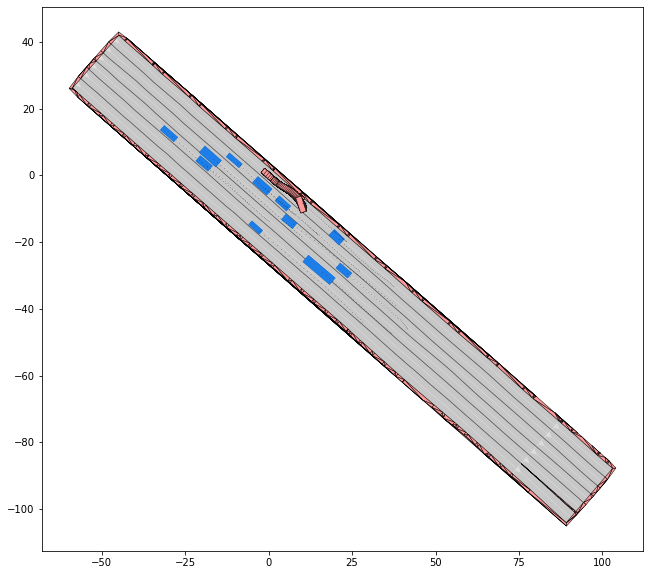

In [146]:
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)

#draw 50 trajectories

n_traj_draw=50
offset=350

plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(road_boundary_sg_triangles)

draw_object(trajectories[offset:offset+n_traj_draw])
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

## 2.1 Check if trajectory is within the road

### 2.1.1 Triangulation

In [147]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(waypoints):
        if trajectory_enclosure_polygons_static(road_polygons,car_half_length, car_half_width, el[0:0])==-1:    
            candidate_trajectories.append(trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_triangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.018906450271606444 sec.


### 2.1.2 OBB rectangles

In [148]:
road_boundary_sg_rectangles = boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles', return_scenario_obstacle=False)

num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(waypoints):
        if trajectory_enclosure_polygons_static(road_polygons,car_half_length, car_half_width, el[0:0])==-1:    
            candidate_trajectories.append(trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

Time for 1000 trajectory checks: 0.009766650199890137 sec.


## 2.2 Collisions between ego-vehicle trajectories and trajectory predictions

In [149]:
def get_scenario_dynamic_obstacles_list(scenario):
    dyn_obstacles_list=list()

    for dyn_obst in scenario.dynamic_obstacles:
        if isinstance(dyn_obst.prediction,TrajectoryPrediction):
            co=create_collision_object(dyn_obst.prediction)
            co, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
            dyn_obstacles_list.append(co)
        else:
            if isinstance(dyn_obst.prediction,SetBasedPrediction):
                co=create_collision_object(dyn_obst.prediction)
                dyn_obstacles_list.append(co)    
            else:
                raise Exception('Unknown dynamic obstacle prediction type: ' + str(type(dyn_obst.prediction))) 
    return dyn_obstacles_list

In [150]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)

In [151]:
num_trials=10
cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='box2d')
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")
res_dynamic=np.asarray(res_dynamic)

Time for 1000 trajectory checks: 0.0064384698867797855 sec.


## 2.3 Collisions between ego-vehicle trajectories and set-based predictions

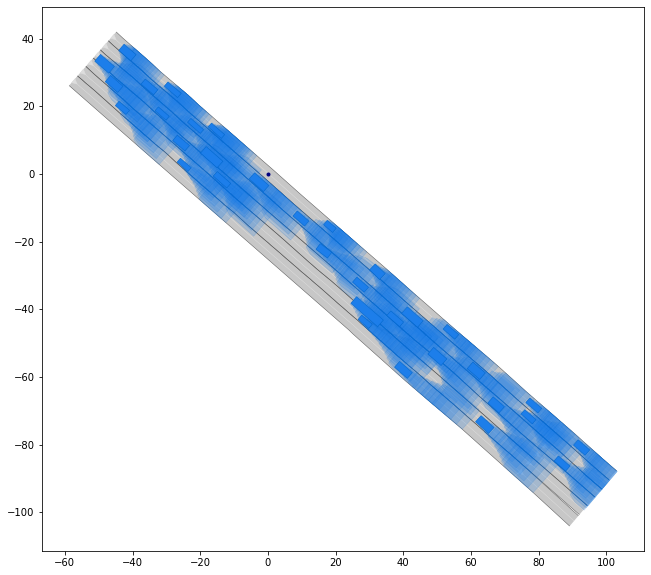

In [152]:
#open the example scenario
scenario, planning_problem_set = open_scenario(directory+scenario_name_set_prediction+'.xml')


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

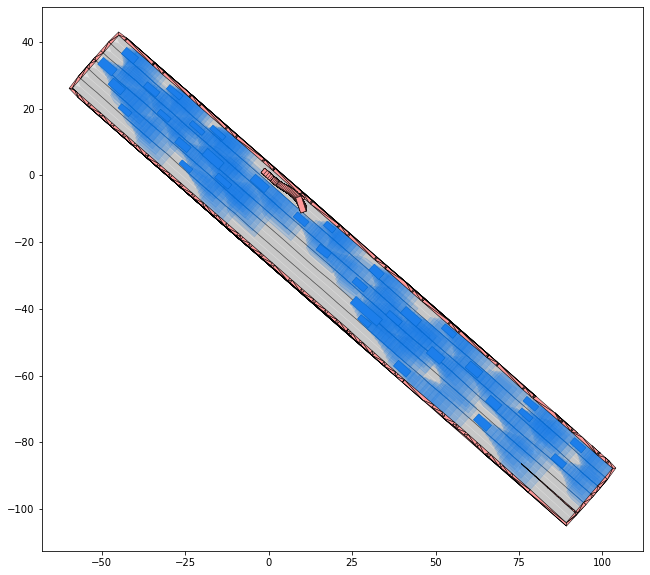

In [153]:
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
    
#draw 50 trajectories

n_traj_draw=50
offset=350

plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(road_boundary_sg_triangles)

draw_object(trajectories[offset:offset+n_traj_draw])
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

In [154]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)


In [155]:
num_trials=10
cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='grid')
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")
res_dynamic=np.asarray(res_dynamic)

Time for 1000 trajectory checks: 0.006194305419921875 sec.
